Epoch 1: Train Acc=0.8888, Val Acc=0.6875
Epoch 2: Train Acc=0.9377, Val Acc=0.8750
Epoch 3: Train Acc=0.9561, Val Acc=0.6250
Epoch 4: Train Acc=0.9571, Val Acc=0.8125
Epoch 5: Train Acc=0.9691, Val Acc=0.8125
Epoch 6: Train Acc=0.9714, Val Acc=0.7500
Epoch 7: Train Acc=0.9734, Val Acc=0.8125
Epoch 8: Train Acc=0.9743, Val Acc=0.6875
Epoch 9: Train Acc=0.9774, Val Acc=0.6250
Epoch 10: Train Acc=0.9806, Val Acc=0.8125
Epoch 11: Train Acc=0.9873, Val Acc=0.8750
Epoch 12: Train Acc=0.9877, Val Acc=0.6875
Epoch 13: Train Acc=0.9896, Val Acc=0.8750
Epoch 14: Train Acc=0.9908, Val Acc=0.6875
Epoch 15: Train Acc=0.9916, Val Acc=0.9375
Epoch 16: Train Acc=0.9835, Val Acc=0.6250
Epoch 17: Train Acc=0.9883, Val Acc=0.7500
Epoch 18: Train Acc=0.9950, Val Acc=0.8750
Epoch 19: Train Acc=0.9969, Val Acc=0.7500
Epoch 20: Train Acc=0.9950, Val Acc=0.8750
Epoch 21: Train Acc=0.9985, Val Acc=0.7500
Epoch 22: Train Acc=0.9971, Val Acc=0.6250
Epoch 23: Train Acc=0.9965, Val Acc=0.8750
Epoch 24: Train Acc=

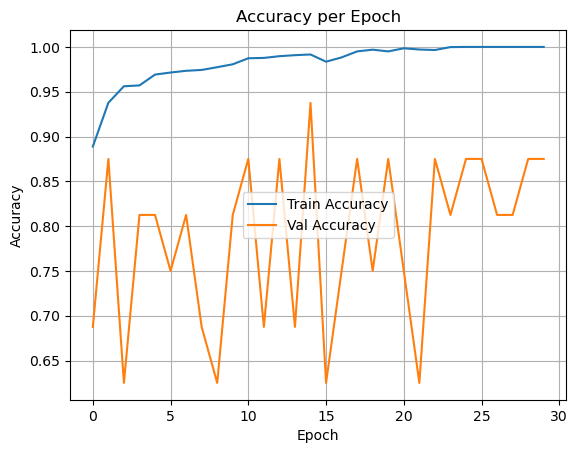

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# ✅ EarlyStopping 클래스 정의
# class EarlyStopping:
#     def __init__(self, patience=3):
#         self.patience = patience
#         self.counter = 0
#         self.best_loss = np.inf
#         self.early_stop = False
#         self.best_model = None

#     def __call__(self, val_loss, model):
#         if val_loss < self.best_loss:
#             self.best_loss = val_loss
#             self.best_model = model.state_dict()
#             self.counter = 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True

# ✅ 데이터 경로 및 전처리
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_loader = DataLoader(datasets.ImageFolder(train_dir, transform=transform), batch_size=32, shuffle=True)
val_loader = DataLoader(datasets.ImageFolder(val_dir, transform=transform), batch_size=32, shuffle=False)
test_loader = DataLoader(datasets.ImageFolder(test_dir, transform=transform), batch_size=32, shuffle=False)

# ✅ SubLeNet 정의
class SubLeNet(nn.Module):
    def __init__(self):
        super(SubLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self._to_linear = self._calc_flatten()

    def _calc_flatten(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 128)
            x = self.pool(torch.relu(self.conv1(dummy)))
            x = self.pool(torch.relu(self.conv2(x)))
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        return x.view(x.size(0), -1)

# ✅ Concatenated LeNet 정의
class ConcatLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.sub1 = SubLeNet()
        self.sub2 = SubLeNet()
        self.sub3 = SubLeNet()
        flat_size = self.sub1._to_linear * 3
        self.fc1 = nn.Linear(flat_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out1 = self.sub1(x)
        out2 = self.sub2(x)
        out3 = self.sub3(x)
        x = torch.cat((out1, out2, out3), dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# ✅ 학습/평가 함수
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            y_true += labels.cpu().tolist()
            y_pred += preds.cpu().tolist()
    acc = correct / len(loader.dataset)
    return total_loss / len(loader), acc, y_true, y_pred

# ✅ 학습 루프 + EarlyStopping
model = ConcatLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# early_stopper = EarlyStopping(patience=3)

train_accs, val_accs = [], []

for epoch in range(30):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # early_stopper(val_loss, model)
    # if early_stopper.early_stop:
    #     print("⛔ Early stopping triggered.")
    #     model.load_state_dict(early_stopper.best_model)
    #     break

# ✅ 테스트 평가
_, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"\n🎯 Test Accuracy: {test_acc:.4f}")
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_loader.dataset.classes))

# ✅ 그래프 출력
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### 두번째 시도도

[Epoch 1] Train Acc: 0.8831 / Val Acc: 0.6250
[Epoch 2] Train Acc: 0.9331 / Val Acc: 0.6250
[Epoch 3] Train Acc: 0.9385 / Val Acc: 0.5625
[Epoch 4] Train Acc: 0.9436 / Val Acc: 0.8125
[Epoch 5] Train Acc: 0.9486 / Val Acc: 0.8125
[Epoch 6] Train Acc: 0.9480 / Val Acc: 0.7500
[Epoch 7] Train Acc: 0.9530 / Val Acc: 0.5625
[Epoch 8] Train Acc: 0.9582 / Val Acc: 0.6250
⛔ Early stopping triggered.

🎯 Final Test Accuracy: 0.7308

🧾 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.99      0.29      0.44       234
   PNEUMONIA       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.84      0.64      0.63       624
weighted avg       0.81      0.73      0.68       624



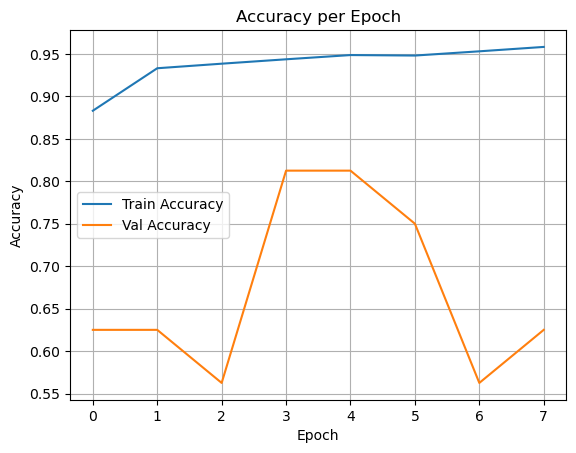

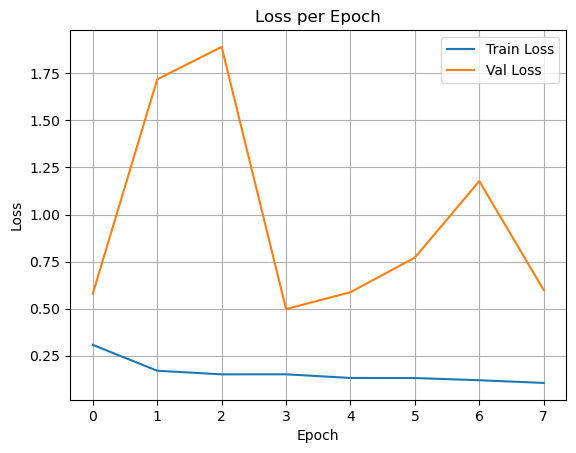

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# ====== 설정 ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

# ====== EarlyStopping 클래스 ======
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ====== DataLoader 설정 ======
transform_train = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

transform_valtest = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transform_train), batch_size=32, shuffle=True)
val_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "val"), transform=transform_valtest), batch_size=32)
test_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transform_valtest), batch_size=32)

# ====== SubLeNet 정의 ======
class SubLeNet(nn.Module):
    def __init__(self):
        super(SubLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self._to_linear = self._calc_flatten()

    def _calc_flatten(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 128)
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return x

# ====== Concatenated Modified LeNet 정의 ======
class ConcatLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.sub1 = SubLeNet()
        self.sub2 = SubLeNet()
        self.sub3 = SubLeNet()
        flat_size = self.sub1._to_linear * 3
        self.fc1 = nn.Linear(flat_size, 120)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out1 = self.sub1(x)
        out2 = self.sub2(x)
        out3 = self.sub3(x)
        x = torch.cat((out1, out2, out3), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ====== 학습 및 평가 함수 ======
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            preds = pred.argmax(1)
            correct += (preds == y).sum().item()
            y_true += y.cpu().tolist()
            y_pred += preds.cpu().tolist()
    return total_loss / len(loader), correct / len(loader.dataset), y_true, y_pred

# ====== 모델 학습 ======
model = ConcatLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
earlystop = EarlyStopping(patience=4)

train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(30):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} / Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)
    earlystop(val_loss, model)
    if earlystop.early_stop:
        print("⛔ Early stopping triggered.")
        model.load_state_dict(earlystop.best_model)
        break

# ====== 테스트 평가 ======
_, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_loader.dataset.classes))

# ====== 그래프 출력 (show only) ======
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os

base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

splits = ['train', 'val', 'test']

for split in splits:
    split_path = os.path.join(base_dir, split)
    print(f"\n📁 {split.upper()} SET:")
    
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            count = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
            print(f"  - {label}: {count} images")


📁 TRAIN SET:
  - NORMAL: 1341 images
  - PNEUMONIA: 3875 images

📁 VAL SET:
  - NORMAL: 8 images
  - PNEUMONIA: 8 images

📁 TEST SET:
  - NORMAL: 234 images
  - PNEUMONIA: 390 images


논문에서도 validation set을 사용하고 있다.
다만, 논문에서는 실제로 train:val:test = 80:10:10 비율로 나눠서,
validation 이미지 수가 충분히 많은 상태에서 안정적으로 학습 및 평가를 하고 있다.
➡️ 데이터 개수 재구성 필요

In [5]:
import os
import random
import shutil

# 경로 설정
base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

# 클래스별 이동
classes = ['NORMAL', 'PNEUMONIA']

for cls in classes:
    train_cls_path = os.path.join(train_dir, cls)
    val_cls_path = os.path.join(val_dir, cls)
    os.makedirs(val_cls_path, exist_ok=True)

    # 이미지 리스트 무작위로 섞기
    images = os.listdir(train_cls_path)
    random.shuffle(images)

    # 상위 10% 이동
    num_to_move = int(len(images) * 0.1)
    selected = images[:num_to_move]

    for img in selected:
        src = os.path.join(train_cls_path, img)
        dst = os.path.join(val_cls_path, img)
        shutil.move(src, dst)

    print(f"[{cls}] Moved {num_to_move} images from train → val.")


[NORMAL] Moved 120 images from train → val.
[PNEUMONIA] Moved 354 images from train → val.


위의 코드 두번 실행 금지!!!

[Epoch 1] Train Acc: 0.8597 / Val Acc: 0.8316
[Epoch 2] Train Acc: 0.9256 / Val Acc: 0.8483
[Epoch 3] Train Acc: 0.9373 / Val Acc: 0.9456
[Epoch 4] Train Acc: 0.9408 / Val Acc: 0.9582
[Epoch 5] Train Acc: 0.9441 / Val Acc: 0.9571
[Epoch 6] Train Acc: 0.9525 / Val Acc: 0.8525
[Epoch 7] Train Acc: 0.9521 / Val Acc: 0.9331
[Epoch 8] Train Acc: 0.9479 / Val Acc: 0.9550
[Epoch 9] Train Acc: 0.9581 / Val Acc: 0.9404
⛔ Early stopping triggered.

🎯 Final Test Accuracy: 0.6987

🧾 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.98      0.20      0.33       234
   PNEUMONIA       0.68      1.00      0.81       390

    accuracy                           0.70       624
   macro avg       0.83      0.60      0.57       624
weighted avg       0.79      0.70      0.63       624



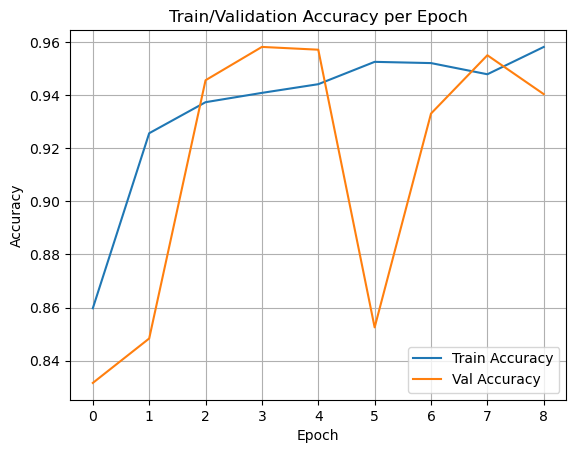

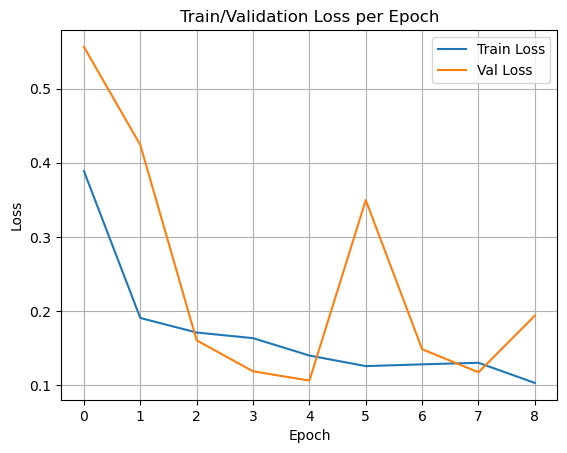

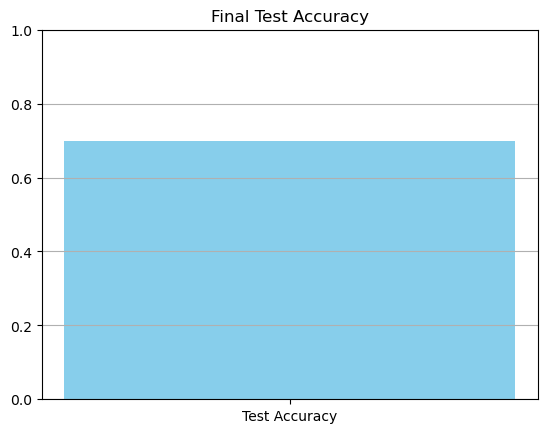

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# ====== 설정 ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

# ====== EarlyStopping 클래스 ======
class EarlyStopping:
    def __init__(self, patience=6):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ====== DataLoader 설정 ======
transform_train = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

transform_valtest = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transform_train), batch_size=32, shuffle=True)
val_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "val"), transform=transform_valtest), batch_size=32)
test_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transform_valtest), batch_size=32)

# ====== SubLeNet 정의 ======
class SubLeNet(nn.Module):
    def __init__(self):
        super(SubLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self._to_linear = self._calc_flatten()

    def _calc_flatten(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 128)
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return x

# ====== Concatenated Modified LeNet 정의 ======
class ConcatLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.sub1 = SubLeNet()
        self.sub2 = SubLeNet()
        self.sub3 = SubLeNet()
        flat_size = self.sub1._to_linear * 3
        self.fc1 = nn.Linear(flat_size, 120)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out1 = self.sub1(x)
        out2 = self.sub2(x)
        out3 = self.sub3(x)
        x = torch.cat((out1, out2, out3), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ====== 학습 및 평가 함수 ======
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            preds = pred.argmax(1)
            correct += (preds == y).sum().item()
            y_true += y.cpu().tolist()
            y_pred += preds.cpu().tolist()
    return total_loss / len(loader), correct / len(loader.dataset), y_true, y_pred

# ====== 모델 학습 ======
model = ConcatLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
earlystop = EarlyStopping(patience=4)

train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(30):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} / Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)
    earlystop(val_loss, model)
    if earlystop.early_stop:
        print("⛔ Early stopping triggered.")
        model.load_state_dict(earlystop.best_model)
        break

# ====== 테스트 평가 ======
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_loader.dataset.classes))

# ====== 그래프 출력 (train/val accuracy & loss + 최종 test accuracy) ======
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.bar(['Test Accuracy'], [test_acc], color='skyblue')
plt.ylim(0, 1)
plt.title("Final Test Accuracy")
plt.grid(axis='y')
plt.show()

In [2]:
import os

base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

splits = ['train', 'val', 'test']

for split in splits:
    split_path = os.path.join(base_dir, split)
    print(f"\n📁 {split.upper()} SET:")
    
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            count = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
            print(f"  - {label}: {count} images")


📁 TRAIN SET:
  - NORMAL: 1087 images
  - PNEUMONIA: 3190 images

📁 VAL SET:
  - NORMAL: 262 images
  - PNEUMONIA: 694 images

📁 TEST SET:
  - NORMAL: 234 images
  - PNEUMONIA: 390 images


#### 세번째 시도

[Epoch 1] Train Acc: 0.8707 / Val Acc: 0.7594
[Epoch 2] Train Acc: 0.9343 / Val Acc: 0.9205
[Epoch 3] Train Acc: 0.9411 / Val Acc: 0.9498
[Epoch 4] Train Acc: 0.9460 / Val Acc: 0.9487
[Epoch 5] Train Acc: 0.9366 / Val Acc: 0.9446
[Epoch 6] Train Acc: 0.9472 / Val Acc: 0.6778
[Epoch 7] Train Acc: 0.9584 / Val Acc: 0.9655
[Epoch 8] Train Acc: 0.9591 / Val Acc: 0.9121
[Epoch 9] Train Acc: 0.9584 / Val Acc: 0.9603
[Epoch 10] Train Acc: 0.9663 / Val Acc: 0.9205
[Epoch 11] Train Acc: 0.9694 / Val Acc: 0.9508
⛔ Early stopping triggered.

🎯 Final Test Accuracy: 0.8333

🧾 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.92      0.61      0.73       234
   PNEUMONIA       0.80      0.97      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.81       624
weighted avg       0.85      0.83      0.82       624



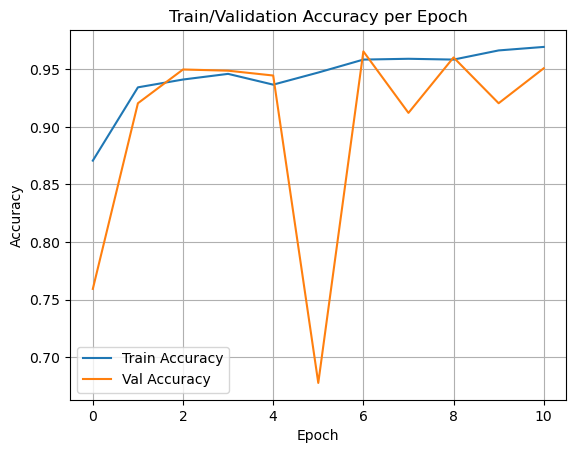

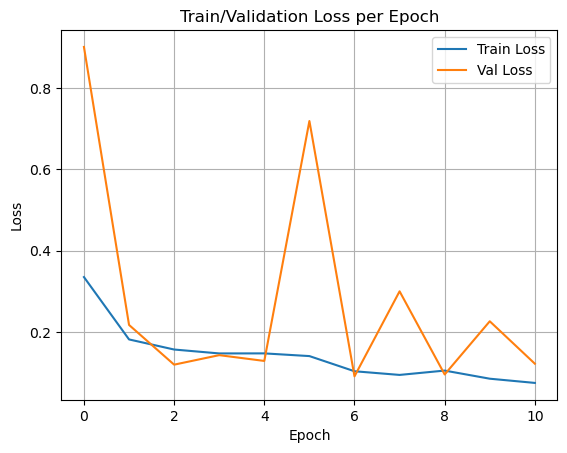

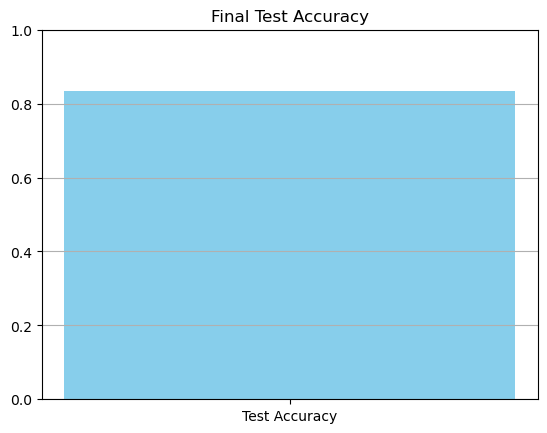

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# ====== 설정 ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

# ====== EarlyStopping 클래스 ======
class EarlyStopping:
    def __init__(self, patience=4):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ====== DataLoader 설정 ======
transform_train = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

transform_valtest = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transform_train), batch_size=32, shuffle=True)
val_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "val"), transform=transform_valtest), batch_size=32)
test_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transform_valtest), batch_size=32)

# ====== 서로 다른 커널의 SubLeNet 정의 ======
class SubLeNet(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=kernel_size)
        self.bn2 = nn.BatchNorm2d(16)
        self._to_linear = self._calc_flatten(kernel_size)

    def _calc_flatten(self, kernel_size):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 128)
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return x

# ====== Concatenated Modified LeNet 정의 ======
class ConcatLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.sub3 = SubLeNet(kernel_size=3)
        self.sub5 = SubLeNet(kernel_size=5)
        self.sub7 = SubLeNet(kernel_size=7)
        total_features = self.sub3._to_linear + self.sub5._to_linear + self.sub7._to_linear
        self.fc1 = nn.Linear(total_features, 120)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out1 = self.sub3(x)
        out2 = self.sub5(x)
        out3 = self.sub7(x)
        x = torch.cat((out1, out2, out3), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ====== 학습 및 평가 함수 ======
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            preds = pred.argmax(1)
            correct += (preds == y).sum().item()
            y_true += y.cpu().tolist()
            y_pred += preds.cpu().tolist()
    return total_loss / len(loader), correct / len(loader.dataset), y_true, y_pred

# ====== 모델 학습 ======
model = ConcatLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
earlystop = EarlyStopping(patience=4)

train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(30):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} / Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)
    earlystop(val_loss, model)
    if earlystop.early_stop:
        print("⛔ Early stopping triggered.")
        model.load_state_dict(earlystop.best_model)
        break

# ====== 테스트 평가 ======
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_loader.dataset.classes))

# ====== 그래프 출력 (train/val accuracy & loss + 최종 test accuracy) ======
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.bar(['Test Accuracy'], [test_acc], color='skyblue')
plt.ylim(0, 1)
plt.title("Final Test Accuracy")
plt.grid(axis='y')
plt.show()


#### 네번째 시도(논문과 달리 개선 실험험)

[Epoch 1] Train Acc: 0.8882 / Val Acc: 0.9079
[Epoch 2] Train Acc: 0.9371 / Val Acc: 0.9529
[Epoch 3] Train Acc: 0.9460 / Val Acc: 0.9519
[Epoch 4] Train Acc: 0.9511 / Val Acc: 0.7793
[Epoch 5] Train Acc: 0.9525 / Val Acc: 0.8577
[Epoch 6] Train Acc: 0.9649 / Val Acc: 0.9278
[Epoch 7] Train Acc: 0.9712 / Val Acc: 0.9571
[Epoch 8] Train Acc: 0.9698 / Val Acc: 0.9644
[Epoch 9] Train Acc: 0.9710 / Val Acc: 0.9655
[Epoch 10] Train Acc: 0.9738 / Val Acc: 0.9498
[Epoch 11] Train Acc: 0.9691 / Val Acc: 0.9498
[Epoch 12] Train Acc: 0.9712 / Val Acc: 0.9613
[Epoch 13] Train Acc: 0.9773 / Val Acc: 0.9665
[Epoch 14] Train Acc: 0.9794 / Val Acc: 0.9686
[Epoch 15] Train Acc: 0.9825 / Val Acc: 0.9508
[Epoch 16] Train Acc: 0.9815 / Val Acc: 0.9686
[Epoch 17] Train Acc: 0.9799 / Val Acc: 0.9623
[Epoch 18] Train Acc: 0.9825 / Val Acc: 0.9686
[Epoch 19] Train Acc: 0.9815 / Val Acc: 0.9707
[Epoch 20] Train Acc: 0.9857 / Val Acc: 0.9707
[Epoch 21] Train Acc: 0.9850 / Val Acc: 0.9697
⛔ Early stopping trigg

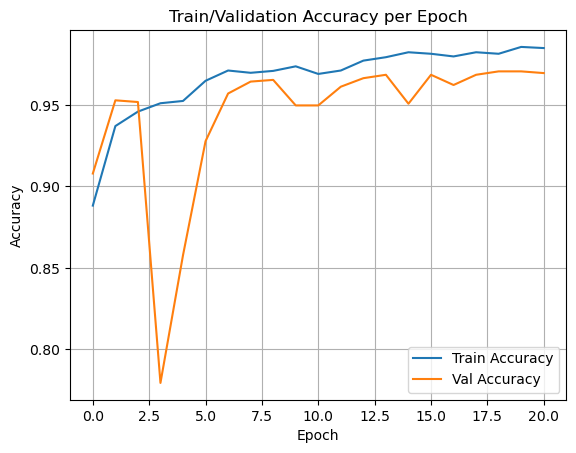

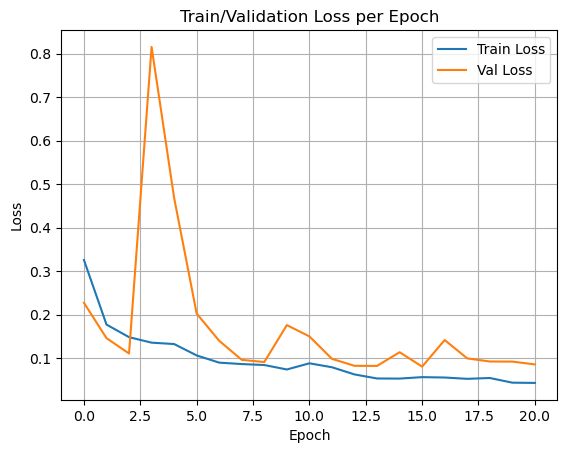

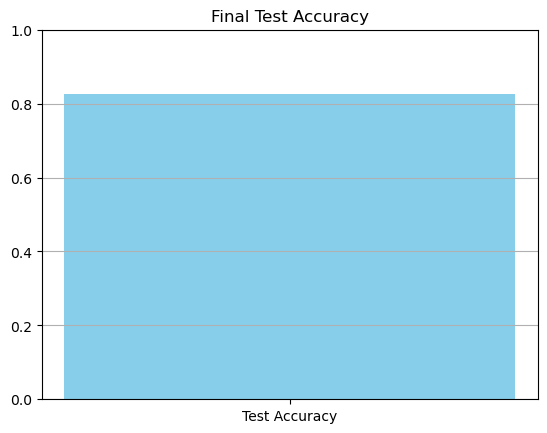

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# ====== 설정 ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

# ====== EarlyStopping 클래스 ======
class EarlyStopping:
    def __init__(self, patience=4):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ====== DataLoader 설정 ======
transform_train = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 추가된 augmentation
    transforms.ToTensor()
])

transform_valtest = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transform_train), batch_size=32, shuffle=True)
val_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "val"), transform=transform_valtest), batch_size=32)
test_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transform_valtest), batch_size=32)

# ====== 서로 다른 커널의 SubLeNet 정의 ======
class SubLeNet(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=kernel_size)
        self.bn2 = nn.BatchNorm2d(16)
        self._to_linear = self._calc_flatten(kernel_size)

    def _calc_flatten(self, kernel_size):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 128)
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return x

# ====== Concatenated Modified LeNet 정의 ======
class ConcatLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.sub3 = SubLeNet(kernel_size=3)
        self.sub5 = SubLeNet(kernel_size=5)
        self.sub7 = SubLeNet(kernel_size=7)
        total_features = self.sub3._to_linear + self.sub5._to_linear + self.sub7._to_linear
        self.fc1 = nn.Linear(total_features, 120)
        self.dropout = nn.Dropout(0.2)  # 개선: dropout 비율 낮춤
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out1 = self.sub3(x)
        out2 = self.sub5(x)
        out3 = self.sub7(x)
        x = torch.cat((out1, out2, out3), dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ====== 학습 및 평가 함수 ======
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            preds = pred.argmax(1)
            correct += (preds == y).sum().item()
            y_true += y.cpu().tolist()
            y_pred += preds.cpu().tolist()
    return total_loss / len(loader), correct / len(loader.dataset), y_true, y_pred

# ====== 클래스 비율 기반 가중치 ======
# NORMAL 총 1583, PNEUMONIA 총 4274 (비율 약 1:1.5)
weights = torch.tensor([1.5, 1.0], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# ====== 모델 학습 ======
model = ConcatLeNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # 개선: Adam → AdamW
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
earlystop = EarlyStopping(patience=5)

train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(30):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} / Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)
    earlystop(val_loss, model)
    if earlystop.early_stop:
        print("⛔ Early stopping triggered.")
        model.load_state_dict(earlystop.best_model)
        break

# ====== 테스트 평가 ======
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_loader.dataset.classes))

# ====== 그래프 출력 (train/val accuracy & loss + 최종 test accuracy) ======
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.bar(['Test Accuracy'], [test_acc], color='skyblue')
plt.ylim(0, 1)
plt.title("Final Test Accuracy")
plt.grid(axis='y')
plt.show()


#### 구조 개선 5번째 시도

[Epoch 1] Train Acc: 0.8744 / Val Acc: 0.9550
[Epoch 2] Train Acc: 0.9334 / Val Acc: 0.8117
[Epoch 3] Train Acc: 0.9472 / Val Acc: 0.9121
[Epoch 4] Train Acc: 0.9528 / Val Acc: 0.9613
[Epoch 5] Train Acc: 0.9546 / Val Acc: 0.7333
[Epoch 6] Train Acc: 0.9612 / Val Acc: 0.9582
[Epoch 7] Train Acc: 0.9640 / Val Acc: 0.9446
[Epoch 8] Train Acc: 0.9605 / Val Acc: 0.8149
[Epoch 9] Train Acc: 0.9633 / Val Acc: 0.9425
[Epoch 10] Train Acc: 0.9624 / Val Acc: 0.9519
[Epoch 11] Train Acc: 0.9717 / Val Acc: 0.9540
[Epoch 12] Train Acc: 0.9717 / Val Acc: 0.9644
[Epoch 13] Train Acc: 0.9719 / Val Acc: 0.9550
[Epoch 14] Train Acc: 0.9747 / Val Acc: 0.8902
[Epoch 15] Train Acc: 0.9736 / Val Acc: 0.9592
[Epoch 16] Train Acc: 0.9771 / Val Acc: 0.9446
[Epoch 17] Train Acc: 0.9797 / Val Acc: 0.9498
[Epoch 18] Train Acc: 0.9787 / Val Acc: 0.9613
[Epoch 19] Train Acc: 0.9822 / Val Acc: 0.9613
[Epoch 20] Train Acc: 0.9811 / Val Acc: 0.9435
[Epoch 21] Train Acc: 0.9818 / Val Acc: 0.9665
[Epoch 22] Train Acc: 

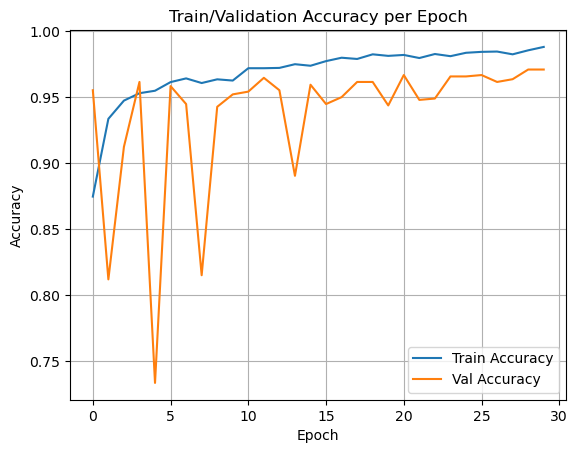

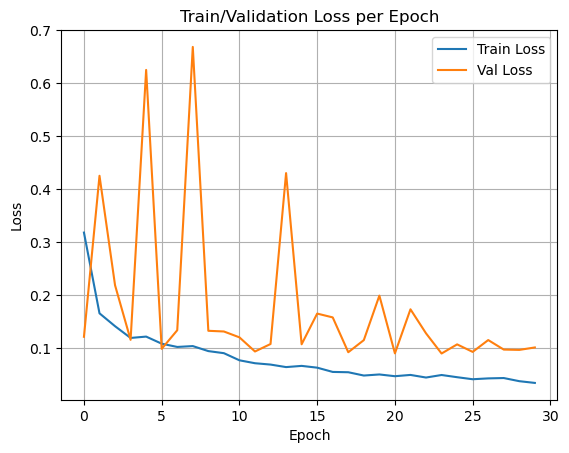

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# ====== 설정 ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

# ====== EarlyStopping 클래스 ======
class EarlyStopping:
    def __init__(self, patience=6):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ====== 데이터 전처리 및 DataLoader ======
transform_train = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

transform_valtest = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transform_train), batch_size=32, shuffle=True)
val_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "val"), transform=transform_valtest), batch_size=32)
test_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transform_valtest), batch_size=32)

# ====== Improved Concatenated LeNet 정의 ======
class ImprovedConcatenatedLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        self.flattened_size = self._get_flatten_size()
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 128, 128)
            x1 = self.branch1(x)
            x2 = self.branch2(x)
            return torch.cat((x1, x2), dim=1).view(1, -1).size(1)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x = torch.cat((x1, x2), dim=1)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# ====== 학습 및 평가 함수 ======
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            preds = pred.argmax(1)
            correct += (preds == y).sum().item()
            y_true += y.cpu().tolist()
            y_pred += preds.cpu().tolist()
    return total_loss / len(loader), correct / len(loader.dataset), y_true, y_pred

# ====== 모델 학습 ======
model = ImprovedConcatenatedLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
earlystop = EarlyStopping(patience=6)

train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(30):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} / Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)
    earlystop(val_loss, model)
    if earlystop.early_stop:
        print("⛔ Early stopping triggered.")
        model.load_state_dict(earlystop.best_model)
        break

# ====== 테스트 평가 ======
_, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_loader.dataset.classes))

# ====== 그래프 출력 ======
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


#### 6번째 시도 (논문에 적힌 내용만 반영)

[Epoch 1] Train Acc: 0.8665 / Val Acc: 0.9425
[Epoch 2] Train Acc: 0.9458 / Val Acc: 0.9498
[Epoch 3] Train Acc: 0.9551 / Val Acc: 0.9331
[Epoch 4] Train Acc: 0.9570 / Val Acc: 0.9561
[Epoch 5] Train Acc: 0.9610 / Val Acc: 0.9289
[Epoch 6] Train Acc: 0.9603 / Val Acc: 0.9582
[Epoch 7] Train Acc: 0.9712 / Val Acc: 0.9623
[Epoch 8] Train Acc: 0.9759 / Val Acc: 0.9603
[Epoch 9] Train Acc: 0.9783 / Val Acc: 0.9592
[Epoch 10] Train Acc: 0.9792 / Val Acc: 0.9351
[Epoch 11] Train Acc: 0.9808 / Val Acc: 0.9571
[Epoch 12] Train Acc: 0.9876 / Val Acc: 0.9644
[Epoch 13] Train Acc: 0.9876 / Val Acc: 0.9435
[Epoch 14] Train Acc: 0.9878 / Val Acc: 0.9644
[Epoch 15] Train Acc: 0.9939 / Val Acc: 0.9676
[Epoch 16] Train Acc: 0.9928 / Val Acc: 0.9676
[Epoch 17] Train Acc: 0.9949 / Val Acc: 0.9623
[Epoch 18] Train Acc: 0.9965 / Val Acc: 0.9623
[Epoch 19] Train Acc: 0.9967 / Val Acc: 0.9655
[Epoch 20] Train Acc: 0.9993 / Val Acc: 0.9676

🎯 Final Test Accuracy: 0.7756

🧾 Classification Report:

           

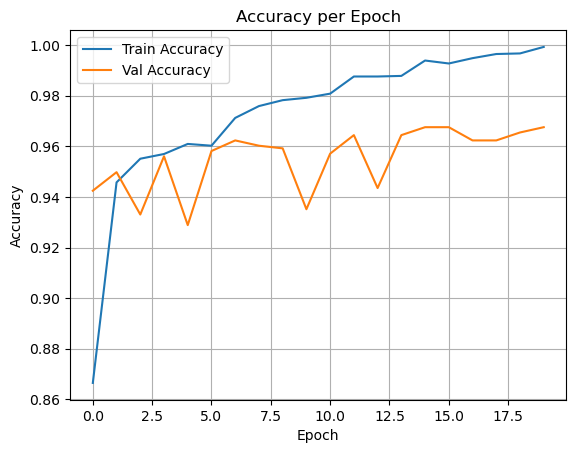

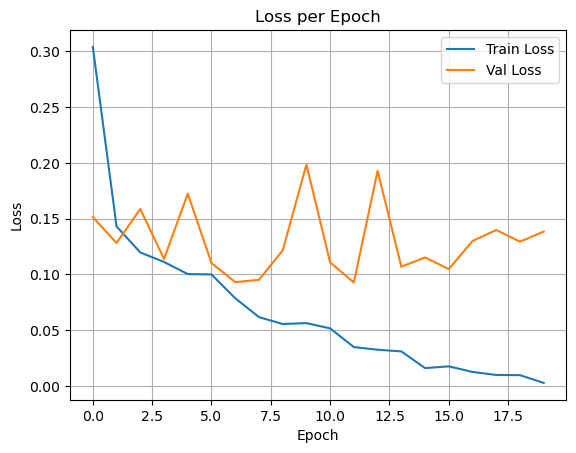

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# ====== 설정 ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

# ====== 데이터 전처리 및 DataLoader ======
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transform), batch_size=32, shuffle=True)
val_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "val"), transform=transform), batch_size=32)
test_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transform), batch_size=32)

# ====== Concatenated LeNet 정의 (논문 구조 기반) ======
class ConcatenatedLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        self.flattened_size = self._get_flatten_size()
        self.fc1 = nn.Linear(self.flattened_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def _get_flatten_size(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 128)
            x1 = self.branch1(dummy)
            x2 = self.branch2(dummy)
            return torch.cat((x1, x2), dim=1).view(1, -1).size(1)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x = torch.cat((x1, x2), dim=1)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# ====== 학습 및 평가 함수 ======
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            preds = pred.argmax(1)
            correct += (preds == y).sum().item()
            y_true += y.cpu().tolist()
            y_pred += preds.cpu().tolist()
    return total_loss / len(loader), correct / len(loader.dataset), y_true, y_pred

# ====== 학습 루프 ======
model = ConcatenatedLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(20):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} / Val Acc: {val_acc:.4f}")

# ====== 테스트 평가 ======
_, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_loader.dataset.classes))

# ====== 그래프 시각화 ======
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()
